In [1]:
import numpy as np
import matplotlib.pylab as plt
import pinocchio as pin

from bullet_utils.env import BulletEnv
# from robot_properties_nyu_finger.wrapper import NYUFingerDoubleRobot, NYUFingerDoubleConfig
from robot_properties_nyu_finger.config import NYUFingerDoubleConfig0, NYUFingerDoubleConfig1
from robot_properties_nyu_finger.wrapper import NYUFingerRobot

from dynamic_graph_head import ThreadHead, SimHead, SimVicon, HoldPDController

# Example controller used for demonstration.

In [2]:
# function for calculating position matrix
def cal_pose(pin_robot, id_ee):
    '''
    calculate position matrix (transition and rotation)
    '''
    # get frame id
    frame = pin_robot.model.getFrameId(id_ee)

    # get pose
    return pin.updateFramePlacement(pin_robot.model, pin_robot.data, frame)


# function for calculating jacobian matrix
def cal_oriented_j(pin_robot, id_ee, q):
    '''
    calculate oriented jacobian of the end effector
    '''
    # get frame id
    frame = pin_robot.model.getFrameId(id_ee)

    # get pose
    pose = pin.updateFramePlacement(pin_robot.model, pin_robot.data, frame)

    # get oriented jacobian
    body_jocobian = pin.computeFrameJacobian(pin_robot.model, pin_robot.data, q, frame)
    Ad = np.zeros((6, 6))
    Ad[:3, :3] = pose.rotation
    Ad[3:, 3:] = pose.rotation

    return Ad @ body_jocobian


# TODO: given position, return desired angle
def cal_inverseK():
    pass


# controls for calculation
class Control:
    def __init__(self, param0, param1):
        # setup control parameters, eg. P and D/gain and D/spring and damping const
        self.set_control(param0, param1)
    
    def set_control(self, param0, param1):
        # setup control parameters
        self.param0 = param0
        self.param1 = param1
    
    def cal_torque(self):
        # given desire position and velocity, calculate the torques for all joints
        raise NotImplementedError

        
class PDControl(Control):
    def cal_torque(self, q_ref, q, dq_ref, dq):
        # calculate error
        error = q_ref - q # the position error for all the joints (it's a 3D vector)
        d_error = dq_ref - dq # the velocity error for all the joints

        # calculate torque
        joint_torques = self.param0 * error + self.param1 * d_error

        return joint_torques
    
    
class VelocityControl(Control):
    def cal_torque(self, x_ref, x_meas, dx_ref, q, dq, jacobian):
        # velocity part of jacobian
        Jov = jacobian[:3]
        # calculate inverse Jacobian
        if np.abs(q[2] < 0.05):
            Jov_inv = np.linalg.pinv(Jov + 1e-4*np.eye(3))
        else:
            Jov_inv = np.linalg.pinv(Jov)
        
        # calculate torque
        dx_des = dx_ref + self.param0 * (x_ref - x_meas)
        dq_des = Jov_inv @ dx_des        
        d_error = dq_des - dq
        joint_torques = self.param1 * d_error
        
        return joint_torques
    
    
class ImpedanceControl(Control):
    def cal_torque(self, x_ref, x_meas, dx_ref, dq, jacobian):
        # velocity part of jacobian
        Jov = jacobian[:3]
        
        # calculate torque
        dx_meas = Jov.dot(dq)        
        des_force = self.param0.dot(x_ref - x_meas) + self.param1.dot(dx_ref - dx_meas)
        joint_torques = Jov.T.dot(des_force)

        return joint_torques
    

# controllers for running
class Controller:
    def __init__(self, head, id_ee, param0, param1, control, total_time, dt=0.001):
        # setup head
        self.head = head
        # pos and vel is reference, will update automatically
        self.joint_positions = self.head.get_sensor('joint_positions')
        self.joint_velocities = self.head.get_sensor('joint_velocities')
        
        # setup pinocchio robot model
        self.id = id_ee
        if self.id == 'finger0_lower_to_tip_joint':
            self.robot = NYUFingerDoubleConfig0.buildRobotWrapper()
        else:
            self.robot = NYUFingerDoubleConfig1.buildRobotWrapper()
        
        # setup control
        self.control = control(param0, param1)
        self.hold_control = PDControl(4, .4)  # hold still in the end of simulation
        self.hold_time = 1  # second
        
        # setup steps
        self.total_time = total_time
        self.dt = dt
        self.current_step = 0
    
    def set_target(self, des_pos, des_vel=None):
        self.des_pos = des_pos
        if des_vel is None:
            self.des_vel = np.zeros(self.robot.nv)
        else:
            self.des_vel = des_vel
    
    def warmup(self, thread):
        pass
    
    def run(self, thread):        
        # update robot kinematics
        self.robot.framesForwardKinematics(self.joint_positions)
        
        # switch to PD control and hold still for last seconds
        self.current_step += 1
        if self.current_step >= int((self.total_time-self.hold_time)/self.dt):
            if self.current_step == int((self.total_time-self.hold_time)/self.dt):
                # set current position (copy of joint pos) as dev_pos and 0 as des_vel
                self.set_target(np.array(self.joint_positions))
            self.tau = self.hold_control.cal_torque(self.des_pos, self.joint_positions, self.des_vel, self.joint_velocities)
            self.head.set_control('ctrl_joint_torques', self.tau)
            return False
        return True


class PDController(Controller):
    def __init__(self, head, id_ee, param0, param1, total_time, des_pos, des_vel=None):
        super().__init__(head, id_ee, param0, param1, PDControl, total_time)
        self.set_target(des_pos, des_vel)
    
    def run(self, thread):
        if super().run(thread):
            self.tau = self.control.cal_torque(self.des_pos, self.joint_positions, self.des_vel, self.joint_velocities)
            self.head.set_control('ctrl_joint_torques', self.tau)


class VelocityController(Controller):
    def __init__(self, head, id_ee, param0, param1, total_time, center, radius, speed=np.pi):
        super().__init__(head, id_ee, param0, param1, VelocityControl, total_time)
        
        # calculate circle locus
        self.locus = self.circular_locus(center, radius, total_time-self.hold_time, self.dt, speed)
        self.set_target(*self.locus[self.current_step])

    @staticmethod
    def circular_locus(center, radius, total_time, dt, w):
        '''
        calculate desire circular locus in xz plane
        '''
        length = int(total_time/dt) + 5  # switch controller has 1 extra run, +5 to ensure no index error
        locus = []
        for i in range(length):
            t = dt * i
            x_ref = np.array([center[0] + radius * np.sin(w * t),
                              center[1],
                              center[2] + radius * np.cos(w * t)])
            dx_ref = np.array([radius * w * np.cos(w * t),
                               0.,
                               -radius * w * np.sin(w * t)])
            locus.append((x_ref, dx_ref))

        return locus
        
    def run(self, thread):        
        if super().run(thread):        
            # calculate position and oriented jacobian
            pose_trans = cal_pose(self.robot, self.id).translation
            oj = cal_oriented_j(self.robot, self.id, self.joint_positions)

            self.tau = self.control.cal_torque(self.des_pos, pose_trans, self.des_vel, self.joint_positions, self.joint_velocities, oj)
            self.head.set_control('ctrl_joint_torques', self.tau)

            # update target
            self.set_target(*self.locus[self.current_step])

            
class ImpedanceController(Controller):
    def __init__(self, head, id_ee, param0, param1, total_time, des_pos, des_vel=None):
        super().__init__(head, id_ee, param0, param1, ImpedanceControl, total_time)
        self.set_target(des_pos, des_vel)
    
    def run(self, thread):
        if super().run(thread):        
            # calculate position and oriented jacobian
            pose_trans = cal_pose(self.robot, self.id).translation
            oj = cal_oriented_j(self.robot, self.id, self.joint_positions)

            self.tau = self.control.cal_torque(self.des_pos, pose_trans, self.des_vel, self.joint_velocities, oj)     
            self.head.set_control('ctrl_joint_torques', self.tau)

# Init the BulletEnv and setup the robot in it.

In [3]:
bullet_env = BulletEnv()  # BulletEnvWithGround()

# Create a robot instance. This initializes the simulator as well.
config0 = NYUFingerDoubleConfig0()
config1 = NYUFingerDoubleConfig1()
finger0 = NYUFingerRobot(config=config0)
finger1 = NYUFingerRobot(config=config1)
id0 = 'finger0_lower_to_tip_joint'
id1 = 'finger1_lower_to_tip_joint'
bullet_env.add_robot(finger0)
bullet_env.add_robot(finger1)

# Setup the simulated head and the thread_head.

The `thread_head` is the central object which executes the actul setup. It also orchastrates data logging and streaming (for plotting) of data.

In [4]:
dt = 0.001

head0 = SimHead(finger0, vicon_name='solo12', with_sliders=False)
head1 = SimHead(finger1, vicon_name='solo12', with_sliders=False)
thread_head = ThreadHead(
    dt, # dt.
    [HoldPDController(head0, 4, .4), HoldPDController(head1, 4, .4)], # Safety controllers.
#     {'finger0': head0},
    {'finger0': head0, 'finger1': head1}, # Heads to read / write from.
    [     # Utils.
#         ('vicon', SimVicon(['solo12/solo12']))  # not using it anyway
    ], 
    bullet_env # Environment to step.
)

Hello world from websocket thread. <ThreadHead(Thread-4, initial)>


# Initialize the controller and run simulation

  Not logging 'head' as field type '<class 'dynamic_graph_head.sim_head.SimHead'>' is unsupported
  Not logging 'id' as field type '<class 'str'>' is unsupported
  Not logging 'robot' as field type '<class 'pinocchio.robot_wrapper.RobotWrapper'>' is unsupported
  Not logging 'control' as field type '<class '__main__.VelocityControl'>' is unsupported
  Not logging 'hold_control' as field type '<class '__main__.PDControl'>' is unsupported
  Not logging 'locus' as field type '<class 'list'>' is unsupported
  Not logging 'head' as field type '<class 'dynamic_graph_head.sim_head.SimHead'>' is unsupported
  Not logging 'id' as field type '<class 'str'>' is unsupported
  Not logging 'robot' as field type '<class 'pinocchio.robot_wrapper.RobotWrapper'>' is unsupported
  Not logging 'control' as field type '<class '__main__.PDControl'>' is unsupported
  Not logging 'hold_control' as field type '<class '__main__.PDControl'>' is unsupported
!!! ThreadHead: Start streaming data.
!!! ThreadHead: St

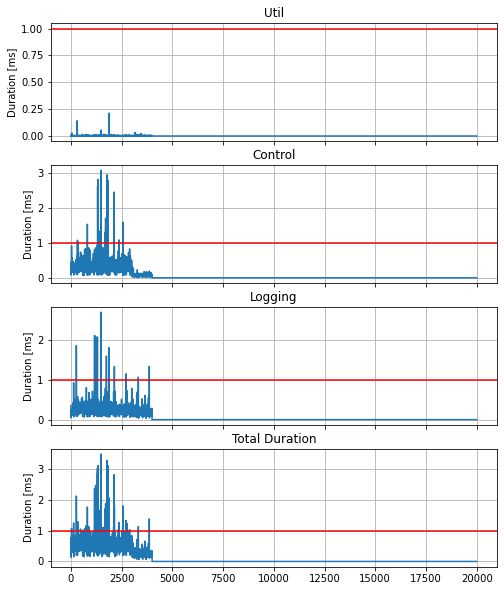

In [5]:
sim_time = 4.0  # seconds
finger0_controller = 1
finger1_controller = 0

if finger0_controller == 0:
    # finger0 PD
    P = np.array([4,4,3])
    D = np.array([.5,.4,.2])
    ctrl0 = PDController(head0, id0, P, D, sim_time, np.array([0,0,np.pi/2]))
    q0 = np.array(NYUFingerDoubleConfig0.initial_configuration)
    dq0 = np.array(NYUFingerDoubleConfig0.initial_velocity)
    thread_head.heads['finger0'].reset_state(q0, dq0)
elif finger0_controller == 1:
    # finger0 velocity
    gain = 1.
    D = np.array([0.3, 0.3, 0.3])
    center = [-0.0506, -0.05945, 0.05]
    center[0] -= 0.1
    center[1] -= 0.05  # avoid two robot touching
    center[2] += 0.2
    radius = 0.04
    ctrl0 = VelocityController(head0, id0, gain, D, sim_time, center, radius, np.pi*3)
    q0 = np.array([0., -0.5, 1])
    dq0 = np.array(NYUFingerDoubleConfig0.initial_velocity)
    thread_head.heads['finger0'].reset_state(q0, dq0)
else:
    # # finger0 impedance
    K = np.diag([50,50,10])
    D = np.diag([5,5,0])
    ctrl0 = ImpedanceController(head0, id0, K, D, sim_time, np.array([-0.051-0.1, -0.059, 0.05+0.1]))
    q0 = np.array(NYUFingerDoubleConfig0.initial_configuration)
    dq0 = np.array(NYUFingerDoubleConfig0.initial_velocity)
    thread_head.heads['finger0'].reset_state(q0, dq0)

if finger1_controller == 0:
    # finger1 PD
    P = np.array([4,4,3])
    D = np.array([.5,.4,.2])
    ctrl1 = PDController(head1, id1, P, D, sim_time, np.array([0,0,np.pi/2]))
    q1 = np.array(NYUFingerDoubleConfig1.initial_configuration)
    dq1 = np.array(NYUFingerDoubleConfig1.initial_velocity)
    thread_head.heads['finger1'].reset_state(q1, dq1)
elif finger1_controller == 1:
    # finger1 velocity
    gain = 1.
    D = np.array([0.3, 0.3, 0.3])
    center = [0.0506947, 0.0594499, 0.05]
    center[0] += 0.1
    center[1] += 0.05  # avoid two robot touching
    center[2] += 0.2
    radius = 0.04
    ctrl1 = VelocityController(head1, id1, gain, D, sim_time, center, radius, -np.pi*3)
    q1 = np.array([0., -0.5, 1])
    dq1 = np.array(NYUFingerDoubleConfig1.initial_velocity)
    thread_head.heads['finger1'].reset_state(q1, dq1)
else:
    # finger1 impedance
    K = np.diag([50,50,10])
    D = np.diag([5,5,0])
    ctrl1 = ImpedanceController(head1, id1, K, D, sim_time, np.array([0.051+0.1, 0.059, 0.05+0.1]))
    q1 = np.array(NYUFingerDoubleConfig1.initial_configuration)
    dq1 = np.array(NYUFingerDoubleConfig1.initial_velocity)
    thread_head.heads['finger1'].reset_state(q1, dq1)

# start simulation
thread_head.switch_controllers((ctrl0, ctrl1))

thread_head.start_streaming()
thread_head.start_logging()

thread_head.sim_run(int(sim_time/dt), sleep=True)

thread_head.stop_streaming()
thread_head.stop_logging()

# Plot timing information.
thread_head.plot_timing()